In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg' # For mac users with Retina display

import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import pandas as pd
import healpy as hp
import seaborn as sns
import sys, pickle, gzip
from astropy.io import fits


import curvspec.master as cs
import hpyroutines.utils as hpy
import hpyroutines.apo as hpa
from astropy.table import Table

from cosmojo.universe import Cosmo

# from WISExSCOS_cross_redMapper import SetPlotStyle, LoadWISExSCOS, fn_load_redmapper

In [101]:
mask = hp.read_map('/Users/fbianchini/Research/Data/mask_convergence_planck_2015_512.fits')

NSIDE = 512
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [102]:
mask = hp.ud_grade(mask, 128)

In [103]:
mask[mask>0]=1

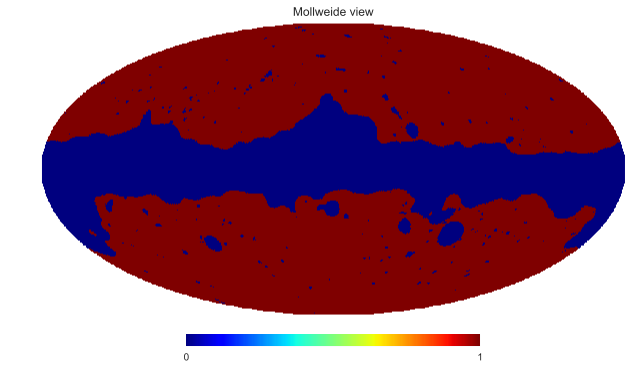

In [104]:
hp.mollview(mask)

In [70]:
m = np.zeros_like(mask, dtype=np.bool)

In [71]:
m[mask==1] = True

In [72]:
mapo = hpa.apodize_mask(m, 30./60)

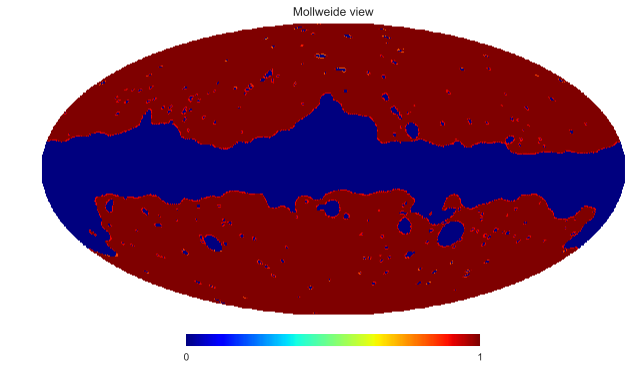

In [73]:
hp.mollview(mapo)

In [42]:
a = hp.read_map('/Volumes/LACIE_SHARE/Data/PlanckDR2/COM_Mask_CMB-confidence-Tmask-IQU-smica-field-Int_2048_R2.01_full.fits')
b = hp.read_map('/Volumes/LACIE_SHARE/Data/PlanckDR2/COM_Mask_CMB-IQU-common-field-MaskInt_2048_R2.01.fits')
# c = hp.read_map('/Volumes/LACIE_SHARE/Data/PlanckDR2/COM_Mask_CMB-PointSrcGalplane-smica-harmonic-mask_2048_R2.00.fits')            

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/Users/fbianchini/anaconda/lib/python2.7/site-packages/healpy/fitsfunc.py:335: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  "assume {}".format(schm))


Ordering converted to RING


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


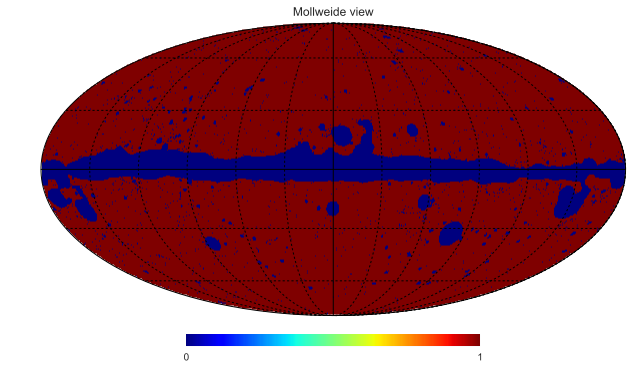

In [3]:
hp.mollview(a)
hp.graticule()

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


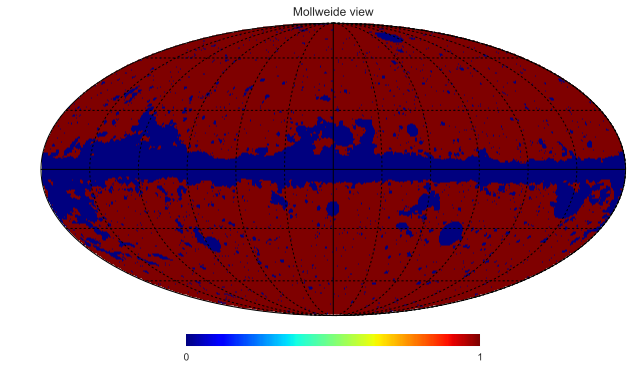

In [4]:
hp.mollview(b)
hp.graticule()

In [130]:
hpy.Sky2Hpx(0,90, 2048, coord='C')

0

0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


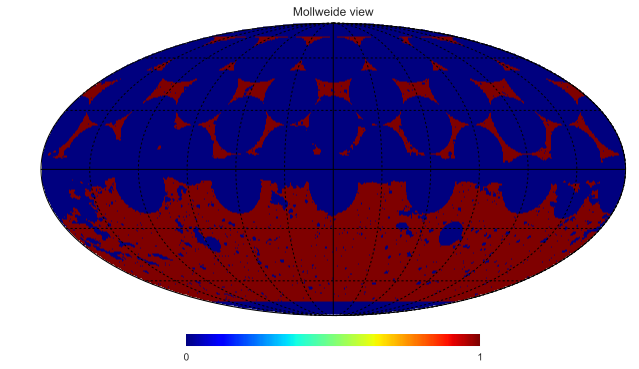

In [5]:
hp.mollview(hpy.GetSourcesMask(np.asarray([0,0,
                                           0,60,120,180,240,300,
                                           0+30,60+30,120+30,180+30,240+30,300+30,
                                           0,60,120,180,240,300,
                                           0+30,60+30,120+30,180+30,240+30,300+30,                                           
                                           0,60,120,180,240,300,
                                          ]),
                               np.asarray([90,-90,
                                           60,60,60,60,60,60,
                                           30+7.5,30+7.5,30+7.5,30+7.5,30+7.5,30+7.5,
                                           30-7.5,30-7.5,30-7.5,30-7.5,30-7.5,30-7.5,
                                           7.5, 7.5, 7.5, 7.5, 7.5, 7.5,
                                           -7.5, -7.5, -7.5, -7.5, -7.5, -7.5,
                                          ]), 
                               2048, 
                               [15], 
                               coord='C') * b)
hp.graticule()

In [97]:
def PlaceCircleMasksOnTheSky(radius):
    lats = []
    
    
    
    hpy.GetSourcesMask(np.asarray([0,0,
                                           0,60,120,180,240,300,
                                           0+30,60+30,120+30,180+30,240+30,300+30,
                                           0,60,120,180,240,300,
                                          ]),
                               np.asarray([90,-90,
                                           60,60,60,60,60,60,
                                           30+7.5,30+7.5,30+7.5,30+7.5,30+7.5,30+7.5,
                                           30-7.5,30-7.5,30-7.5,30-7.5,30-7.5,30-7.5,
                                          ]), 
                               2048, 
                               [15], 
                               coord='C')

In [2]:
def ThrowCircleMasksOnTheSky(radius, mask=None, nside=2048, overlap=0.1, overlap_mask=0.05, fsky=0.1, max_iter=100, return_pix=False):

    full_mask = np.ones(hp.nside2npix(nside))

    if mask is not None:
        full_mask *= mask
    else:
        mask = np.ones(hp.nside2npix(nside))
        
    pix_ones = np.where(full_mask == 1)[0]
    
    i = 0
    xs = []
    ys = []
    zs = []
    while (np.mean(full_mask) > fsky):
        x, y, z = hp.pix2vec(nside,np.random.choice(pix_ones))
        ipix = hp.query_disc(nside, (x, y, z), np.radians(radius))
        cond1 = len(np.where(full_mask[ipix]==0)[0]) < overlap * len(ipix)
        cond2 = len(np.where(mask[ipix]==0)[0]) < overlap_mask * len(ipix)
        if cond1 and cond2:
            full_mask[ipix] = 0.
            pix_ones = np.where(full_mask == 1)[0]
            i = 0 
            xs.append(x)
            ys.append(y)
            zs.append(z)
        else:
            i += 1
            if i > max_iter: break
            
    print 'created %d holes' %len(xs)
    if i !=0:
        print 'exiting with %d iterations'%(i)
    print 'f_sky = %.3f' %full_mask.mean()
    if return_pix:
        return full_mask, (xs, ys, zs)
    else:
        return full_mask

In [3]:
mt, (x,y,z) = ThrowCircleMasksOnTheSky(15, mask=hpy.GetGalMask(2048,lat=10.), max_iter=500, overlap=0.3, return_pix=1)

created 42 holes
exiting with 501 iterations
f_sky = 0.202


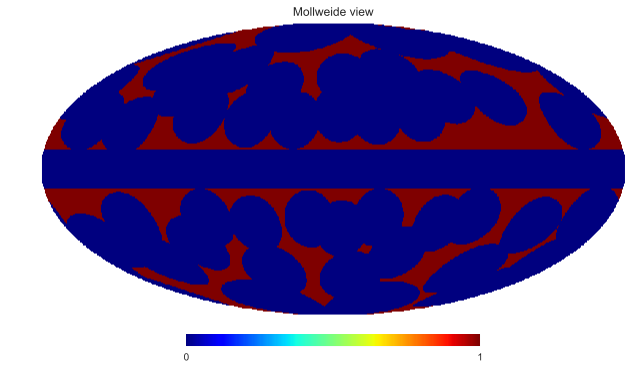

In [4]:
hp.mollview(mt)

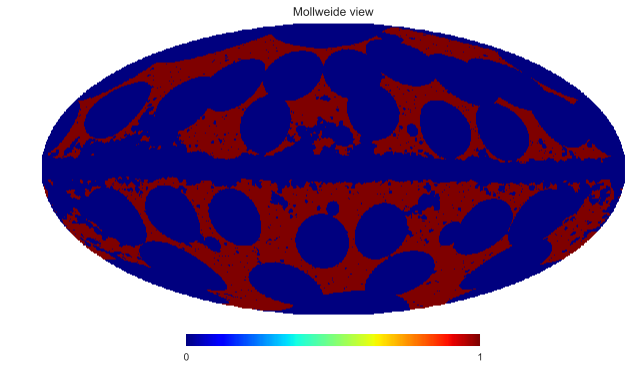

In [172]:
hp.mollview(mt)

In [77]:
hp.vec2pix?

In [5]:
hp.vec2pix(2048,x[0],y[0],z[0])

42635644

In [56]:
np.random.seed(666)

In [57]:
mt2, (x,y,z) = ThrowCircleMasksOnTheSky(15, mask=b, max_iter=1000, overlap=0.3, return_pix=1, fsky=1e-4)

created 31 holes
exiting with 1001 iterations
f_sky = 0.321


In [62]:
np.random.seed(666)

In [63]:
mt3, (x,y,z) = ThrowCircleMasksOnTheSky(15, mask=b, max_iter=2000, overlap=0.3, return_pix=1, fsky=1e-4, overlap_mask=0.1)

created 37 holes
exiting with 2001 iterations
f_sky = 0.229


In [64]:
(mt2 == mt3).all()

False

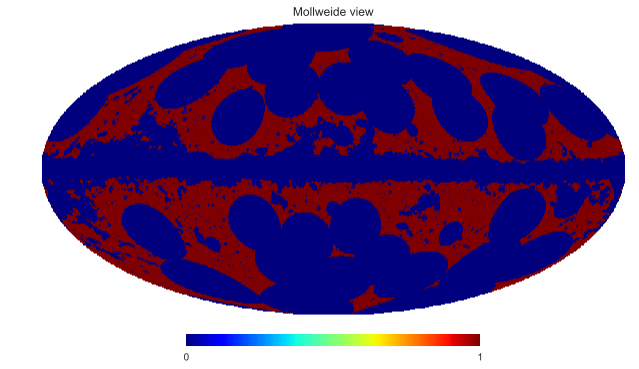

In [65]:
hp.mollview(mt2)

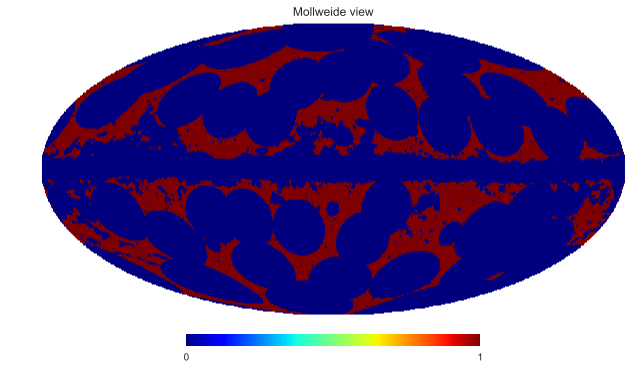

In [66]:
hp.mollview(mt3)

In [55]:
b.mean()*42000/(np.pi*15**2)

46.089611253894113

In [70]:
x[0],y[0],z[0]

(-0.19551531574720296, -0.19419977414927986, -0.96128050486246741)

In [73]:
hp.smoothing?

In [14]:
l = np.arange(2500.)
cls = np.nan_to_num(1/l**2)
cls[0] = 0.

/Users/fbianchini/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in divide
  from ipykernel import kernelapp as app


In [15]:
cls

array([  0.00000000e+00,   1.00000000e+00,   2.50000000e-01, ...,
         1.60384692e-07,   1.60256308e-07,   1.60128077e-07])

In [16]:
mymap = hp.synfast(cls, 1024, pixwin=1, fwhm=np.radians(5./60))

/Users/fbianchini/anaconda/lib/python2.7/site-packages/healpy/sphtfunc.py:296: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning)


Sigma is 2.123305 arcmin (0.000618 rad) 
-> fwhm is 5.000000 arcmin


In [17]:
import curvspec.master as cs


In [39]:
est = cs.Master(np.ones(hp.nside2npix(1024)), lmin=2,lmax=2300,  delta_ell=1,  MASTER=0,  pixwin=1, fwhm_smooth=[5.,5.])

In [40]:
cl_ext = est.get_spectra(mymap)

(1e-07, 1e-06)

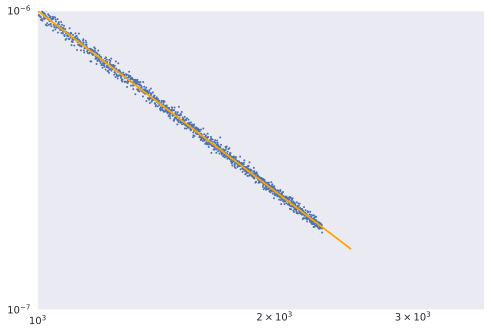

In [41]:
plt.plot(est.lb, cl_ext, 'o', ms=2)
plt.plot(cls,'orange')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1000)
plt.ylim(1e-7,1e-6)

In [76]:
60*6./35

10.285714285714286

In [77]:
for i in xrange(0,10):
    print i

0
1
2
3
4
5
6
7
8
9


In [20]:
mycosmo = Cosmo({'tau':0.06})

In [86]:
tt = mycosmo.cmb_spectra(5000, dl=False)[:,0]

/Users/fbianchini/anaconda/lib/python2.7/site-packages/CosMojo-0.1.0-py2.7.egg/cosmojo/universe.py:416: RuntimeWarning: divide by zero encountered in divide
  fact = 2.*np.pi/(ls*(ls+1)) * 1.e12 * self.pars.TCMB**2.
/Users/fbianchini/anaconda/lib/python2.7/site-packages/CosMojo-0.1.0-py2.7.egg/cosmojo/universe.py:424: RuntimeWarning: invalid value encountered in multiply
  cls[:,i] *= fact


In [21]:
cls_cmb = mycosmo.cmb_spectra(5000, dl=False)

/Users/fbianchini/anaconda/lib/python2.7/site-packages/CosMojo-0.1.0-py2.7.egg/cosmojo/universe.py:416: RuntimeWarning: divide by zero encountered in divide
  fact = 2.*np.pi/(ls*(ls+1)) * 1.e12 * self.pars.TCMB**2.
/Users/fbianchini/anaconda/lib/python2.7/site-packages/CosMojo-0.1.0-py2.7.egg/cosmojo/universe.py:424: RuntimeWarning: invalid value encountered in multiply
  cls[:,i] *= fact


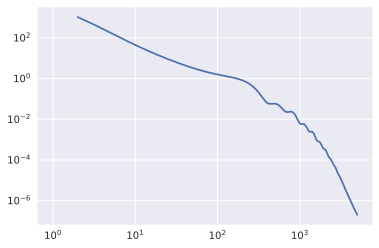

In [87]:
plt.loglog(tt)

In [115]:
tt_map = hp.synfast(tt, 2048, pixwin=0)# fwhm=np.radians(5./60.))

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


0.0 180.0 -180.0 180.0
The interval between parallels is 30 deg -0.00'.
The interval between meridians is 30 deg -0.00'.


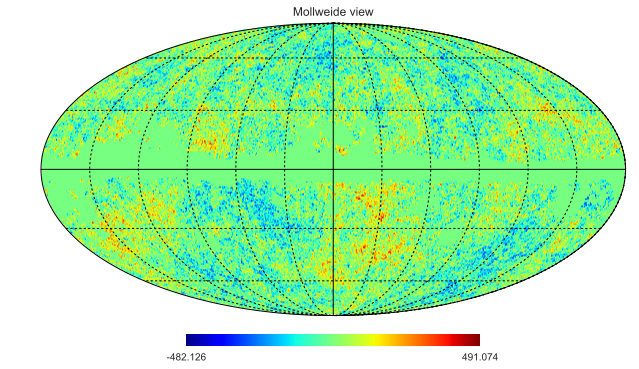

In [92]:
hp.mollview(tt_map*b)
hp.graticule()

In [116]:
hp.write_map('tt_only_nopixwin_nside2048.fits', tt_map)

In [95]:
np.sqrt(0.02)

0.1414213562373095

In [103]:
lb, dlsim = np.loadtxt('/Users/fbianchini/Research/OpticalTau/Dl_sim_wonoise.dat',unpack=1)

In [98]:
fact = np.arange(5001)*(np.arange(5001)+1)/2./np.pi

(100, 2000)

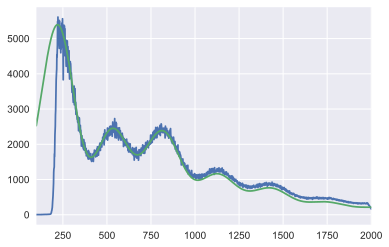

In [101]:
plt.plot(lb, dlsim)
plt.plot(fact*tt)
plt.xlim([100,2000])

In [111]:
lb, dlsmica = np.loadtxt('/Users/fbianchini/Research/OpticalTau/Dl_smica_halfmission1_cross_halfmission2_filt_200_2000_gal080.dat',unpack=1)
lb_old, dlsmica_old = np.loadtxt('/Users/fbianchini/Research/OpticalTau/Dl_smica_halfmission1_cross_halfmission2_filt_200_2000.dat',unpack=1)

(100, 2000)

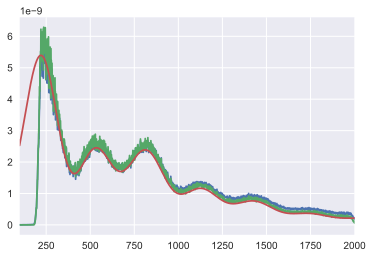

In [112]:
plt.plot(lb_old, dlsmica_old)
plt.plot(lb, dlsmica)
plt.plot(fact*tt/1e12)
plt.xlim([100,2000])

In [118]:
from cosmojo.utils import nl_cmb

In [126]:
ell = np.arange(tt.size)

In [132]:
err_tt = np.sqrt(2./(2*ell+1))*(cls_cmb[:,0]+nl_cmb(45, 5.,5000))
err_ee = np.sqrt(2./(2*ell+1))*(cls_cmb[:,1]+nl_cmb(45*np.sqrt(2), 5.,5000))
err_te = np.sqrt(1./(2*ell+1)*(cls_cmb[:,3]**2 + (nl_cmb(45*np.sqrt(2), 5.,5000)+cls_cmb[:,1])*(nl_cmb(45, 5.,5000)+cls_cmb[:,0])))


(0, 3000)

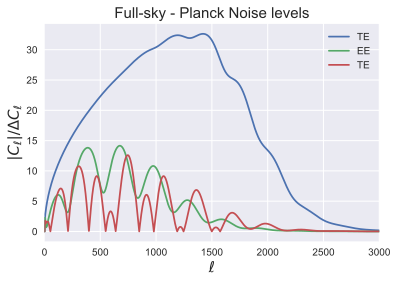

In [138]:
plt.title('Full-sky - Planck Noise levels', size=15)
plt.plot(cls_cmb[:,0]/err_tt, label='TE')
plt.plot(cls_cmb[:,1]/err_ee, label='EE')
plt.plot(np.abs(cls_cmb[:,3])/err_te, label='TE')
plt.xlabel(r'$\ell$', size=15)
plt.ylabel(r'$|C_{\ell}|/\Delta C_{\ell}$', size=15)
plt.legend()
plt.xlim([0,3000])

In [146]:
import hpyroutines.utils as hpy


AttributeError: 'module' object has no attribute 'utils'

In [147]:
filt = hpy.filter_bandpass_1d(2500+1, 200, 2000, 50)


In [152]:
tt_map_filt = hp.synfast(filt*tt[:2501], 2048, pixwin=0)# fwhm=np.radians(5./60.))

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [2]:
from cosmojo.utils import nl_cmb

In [4]:
nltt = nl_cmb(45., 0., lmax=5000)

In [5]:
np.random.seed(666)
ntt_map1 = hp.synfast(nltt, 2048, pixwin=0)# fwhm=np.radians(5./60.))
ntt_map2 = hp.synfast(nltt, 2048, pixwin=0)# fwhm=np.radians(5./60.))

/Users/fbianchini/anaconda/lib/python2.7/site-packages/healpy/sphtfunc.py:296: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning)


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [8]:
hp.write_map('tt_noise1_nopixwin_nside2048.fits', ntt_map1)
hp.write_map('tt_noise2_nopixwin_nside2048.fits', ntt_map2)

        Use :meth:`BinTableHDU.from_columns` for new BINARY tables or :meth:`TableHDU.from_columns` for new ASCII tables instead. [astropy.utils.decorators]


In [4]:
from numba import jit

In [2]:
def GetCorrAlms(clxy, clxx, clyy, nside, lmax=None):
	"""
	Generates correlated gaussian realizations of two fields X and Y 
	which statistics is described by the sets of three Auto- and 
	Cross-spectra clxx, clyy, and clxy. 

	Based on HealPix routine create_alm.
	
	Parameters
	----------
	clxy :  array-like 
		Input cross-power spectrum C_l^{XY}

	clxx :  array-like 
		Input auto-power  spectrum C_l^{XX} of first field

	clyy :  array-like 
		Input auto-power  spectrum C_l^{YY} of second field

	nside : int 
		Healpix resolution

	lmax : int (optional) 
		Maximum multipole 
	

	Returns
	-------
	alm_xx : array-like
		First field Alm coefficients
	
	alm_yy : array-like
		Second field Alm coefficients 

	Notes
	-----
	*  Realizations are returned as *alms* 

	"""

	if lmax is None:
		lmax = 2*nside 
		lmax = int(lmax)

	tot_alm = hp.sphtfunc.Alm.getsize(lmax)  

	alm_xx = np.zeros(tot_alm, dtype=complex)
	alm_yy = np.zeros(tot_alm, dtype=complex)


	# Loop on l: Let's deal with X field coefficients
	# and first term rms_yy1 of the Y field coefficients
	for l in range(0,lmax+1):
		rms_xx = 0.
		rms_yy1 = 0.
		if clxx[l] != 0.: # To avoid division by zero
			rms_xx = np.sqrt(clxx[l])
			rms_yy1 = clxy[l]/rms_xx

		# Treat the m = 0 case
		rand1_r = np.random.normal()
		rand1_i = 0.
		alm_xx.real[l] = rand1_r*rms_xx
		alm_yy.real[l] = rand1_r*rms_yy1

		#Treat the m > 0 cases
		for m in range(1,l+1):
			rand1_r = np.random.normal()/np.sqrt(2.0)
			rand1_i = np.random.normal()/np.sqrt(2.0)
			alm_xx.real[(m*(2*lmax+1-m)/2)+l] = rand1_r*rms_xx
			alm_xx.imag[(m*(2*lmax+1-m)/2)+l] = rand1_i*rms_xx
			alm_yy.real[(m*(2*lmax+1-m)/2)+l] = rand1_r*rms_yy1
			alm_yy.imag[(m*(2*lmax+1-m)/2)+l] = rand1_i*rms_yy1

	# Loop on l: second term rms_yy2 of Y field coefficients
	for l in range(0,lmax+1):
		rms_yy2 = 0.
		if clxx[l] != 0.: # To avoid division by zero
			rms_yy2 = clyy[l] - (clxy[l]/clxx[l])*clxy[l]
			rms_yy2 = np.sqrt(rms_yy2)

		# Treat the m = 0 case
		rand2_r = np.random.normal()
		rand2_i = 0.
		alm_yy.real[l] = alm_yy.real[l] + rand2_r*rms_yy2

		#Treat the m > 0 cases
		for m in range(1,l+1):
			rand2_r = np.random.normal()/np.sqrt(2.0)
			rand2_i = np.random.normal()/np.sqrt(2.0)
			alm_yy.real[(m*(2*lmax+1-m)/2)+l] = alm_yy.real[(m*(2*lmax+1-m)/2)+l] + rand2_r*rms_yy2
			alm_yy.imag[(m*(2*lmax+1-m)/2)+l] = alm_yy.imag[(m*(2*lmax+1-m)/2)+l] + rand2_i*rms_yy2

	return np.nan_to_num(alm_xx), np.nan_to_num(alm_yy)

In [15]:
@jit(nopython=True)
def GetCorrAlmsJit(clxy, clxx, clyy, nside, lmax=None):
	"""
	Generates correlated gaussian realizations of two fields X and Y 
	which statistics is described by the sets of three Auto- and 
	Cross-spectra clxx, clyy, and clxy. 

	Based on HealPix routine create_alm.
	
	Parameters
	----------
	clxy :  array-like 
		Input cross-power spectrum C_l^{XY}

	clxx :  array-like 
		Input auto-power  spectrum C_l^{XX} of first field

	clyy :  array-like 
		Input auto-power  spectrum C_l^{YY} of second field

	nside : int 
		Healpix resolution

	lmax : int (optional) 
		Maximum multipole 
	

	Returns
	-------
	alm_xx : array-like
		First field Alm coefficients
	
	alm_yy : array-like
		Second field Alm coefficients 

	Notes
	-----
	*  Realizations are returned as *alms* 

	"""

	if lmax is None:
		lmax = 2*nside 
		lmax = int(lmax)

	tot_alm = lmax * (2 * lmax + 1 - lmax) // 2 + lmax + 1 #tot_alm = hp.sphtfunc.Alm.getsize(lmax)  

	alm_xx = np.zeros(tot_alm, dtype=complex)
	alm_yy = np.zeros(tot_alm, dtype=complex)


	# Loop on l: Let's deal with X field coefficients
	# and first term rms_yy1 of the Y field coefficients
	for l in range(0,lmax+1):
		rms_xx = 0.
		rms_yy1 = 0.
		if clxx[l] != 0.: # To avoid division by zero
			rms_xx = np.sqrt(clxx[l])
			rms_yy1 = clxy[l]/rms_xx

		# Treat the m = 0 case
		rand1_r = np.random.normal()
		rand1_i = 0.
		alm_xx.real[l] = rand1_r*rms_xx
		alm_yy.real[l] = rand1_r*rms_yy1

		#Treat the m > 0 cases
		for m in range(1,l+1):
			rand1_r = np.random.normal()/np.sqrt(2.0)
			rand1_i = np.random.normal()/np.sqrt(2.0)
			alm_xx.real[(m*(2*lmax+1-m)/2)+l] = rand1_r*rms_xx
			alm_xx.imag[(m*(2*lmax+1-m)/2)+l] = rand1_i*rms_xx
			alm_yy.real[(m*(2*lmax+1-m)/2)+l] = rand1_r*rms_yy1
			alm_yy.imag[(m*(2*lmax+1-m)/2)+l] = rand1_i*rms_yy1

	# Loop on l: second term rms_yy2 of Y field coefficients
	for l in range(0,lmax+1):
		rms_yy2 = 0.
		if clxx[l] != 0.: # To avoid division by zero
			rms_yy2 = clyy[l] - (clxy[l]/clxx[l])*clxy[l]
			rms_yy2 = np.sqrt(rms_yy2)

		# Treat the m = 0 case
		rand2_r = np.random.normal()
		rand2_i = 0.
		alm_yy.real[l] = alm_yy.real[l] + rand2_r*rms_yy2

		#Treat the m > 0 cases
		for m in range(1,l+1):
			rand2_r = np.random.normal()/np.sqrt(2.0)
			rand2_i = np.random.normal()/np.sqrt(2.0)
			alm_yy.real[(m*(2*lmax+1-m)/2)+l] = alm_yy.real[(m*(2*lmax+1-m)/2)+l] + rand2_r*rms_yy2
			alm_yy.imag[(m*(2*lmax+1-m)/2)+l] = alm_yy.imag[(m*(2*lmax+1-m)/2)+l] + rand2_i*rms_yy2

	return alm_xx, alm_yy
# 	return np.nan_to_num(alm_xx), np.nan_to_num(alm_yy)

In [6]:
%timeit GetCorrAlms(np.arange(1001),np.arange(1001)**2,np.arange(1001)**3,512,lmax=1000)

1 loop, best of 3: 4.75 s per loop


In [16]:
%timeit GetCorrAlmsJit(np.arange(1001),np.arange(1001)**2,np.arange(1001)**3,512,lmax=1000)

TypingError: Caused By:
Traceback (most recent call last):
  File "/Users/fbianchini/anaconda/lib/python2.7/site-packages/numba/compiler.py", line 249, in run
    stage()
  File "/Users/fbianchini/anaconda/lib/python2.7/site-packages/numba/compiler.py", line 476, in stage_nopython_frontend
    self.locals)
  File "/Users/fbianchini/anaconda/lib/python2.7/site-packages/numba/compiler.py", line 828, in type_inference_stage
    infer.propagate()
  File "/Users/fbianchini/anaconda/lib/python2.7/site-packages/numba/typeinfer.py", line 717, in propagate
    raise errors[0]
TypingError: Invalid usage of Function(<built-in function zeros>) with parameters (int64, dtype=Function(<type 'complex'>))
 * parameterized
File "<ipython-input-15-5befd5663e4e>", line 48
[1] During: resolving callee type: Function(<built-in function zeros>)
[2] During: typing of call at <ipython-input-15-5befd5663e4e> (48)

Failed at nopython (nopython frontend)
Invalid usage of Function(<built-in function zeros>) with parameters (int64, dtype=Function(<type 'complex'>))
 * parameterized
File "<ipython-input-15-5befd5663e4e>", line 48
[1] During: resolving callee type: Function(<built-in function zeros>)
[2] During: typing of call at <ipython-input-15-5befd5663e4e> (48)

In [7]:
@jit(nopython=True)
def calc_b_cov_TEB(cltt, clee, clbb):

    N = len(cltt)
    res = np.empty((N,N,N))
    for l1 in np.arange(N):
        for l2 in np.arange(N):
            for l3 in np.arange(N):
                res[l1,l2,l3] = cltt[l1] * clee[l2] * clbb[l3]
    return res

In [8]:
def calc_b_cov_TEB_pure(cltt, clee, clbb):

    N = len(cltt)
    res = np.empty((N,N,N))
    for l1 in np.arange(N):
        for l2 in np.arange(N):
            for l3 in np.arange(N):
                res[l1,l2,l3] = cltt[l1] * clee[l2] * clbb[l3]
    return res

In [5]:
l = np.arange(10)

In [12]:
%timeit calc_b_cov_TEB_pure(l,l,l)

1000 loops, best of 3: 1.09 ms per loop


In [11]:
%timeit calc_b_cov_TEB(l,l,l)

10000 loops, best of 3: 19.1 µs per loop
